### 1. Install packages

In [1]:
!pip3 install --upgrade pip
!pip3 install tensorflow-estimator==2.1
!pip3 install tensorflow

  Using cached tensorflow_estimator-2.1.0-py2.py3-none-any.whl (448 kB)
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.13.0
    Uninstalling tensorflow-estimator-2.13.0:
      Successfully uninstalled tensorflow-estimator-2.13.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.13.0 requires tensorflow-estimator<2.14,>=2.13.0, but you have tensorflow-estimator 2.1.0 which is incompatible.
  Obtaining dependency information for tensorflow-estimator<2.14,>=2.13.0 from https://files.pythonhosted.org/packages/72/5c/c318268d96791c6222ad7df1651bbd1b2409139afeb6f468c0f327177016/tensorflow_estimator-2.13.0-py2.py3-none-any.whl.metadata
  Using cached tensorflow_estimator-2.13.0-py2.py3-none-any.whl.metadata (1.3 kB)
Using cached tensorflow_estimator-2.13.0-py2.py3-none-any.whl (440 kB)
  Attempting uninst

In [2]:
!pip3 install torch torchvision torchaudio

### 2. Import libraries

In [3]:
# PyTorch Library
import torch
# PyTorch Neural Network
import torch.nn as nn
# Allows us to transform data
import torchvision.transforms as transforms
# Allows us to download the dataset
import torchvision.datasets as dsets
# Used to graph data and loss curves
import matplotlib.pylab as plt
# Allows us to use arrays to manipulate and store data
import numpy as np
import os
import pandas as pd

from tensorflow.keras.utils import load_img
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torchvision import transforms
# Importing all necessary libraries
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms
import time
from tempfile import TemporaryDirectory

img_width, img_height = 256, 256
# img_width, img_height = 224, 224

2023-09-26 03:44:54.851303: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# Define the function for plotting the channels

def plot_channels(W):
    n_out = W.shape[0]
    n_in = W.shape[1]
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(n_out, n_in)
    fig.subplots_adjust(hspace=0.1)
    out_index = 0
    in_index = 0

    #plot outputs as rows inputs as columns
    for ax in axes.flat:
        if in_index > n_in-1:
            out_index = out_index + 1
            in_index = 0
        ax.imshow(W[out_index, in_index, :, :], vmin=w_min, vmax=w_max, cmap='seismic')
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        in_index = in_index + 1

    plt.show()

In [5]:
# Define the function for plotting the parameters

def plot_parameters(W, number_rows=1, name="", i=0):
    W = W.data[:, i, :, :]
    n_filters = W.shape[0]
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(number_rows, n_filters // number_rows)
    fig.subplots_adjust(hspace=0.4)

    for i, ax in enumerate(axes.flat):
        if i < n_filters:
            # Set the label for the sub-plot.
            ax.set_xlabel("kernel:{0}".format(i + 1))

            # Plot the image.
            ax.imshow(W[i, :], vmin=w_min, vmax=w_max, cmap='seismic')
            ax.set_xticks([])
            ax.set_yticks([])
    plt.suptitle(name, fontsize=10)
    plt.show()

In [7]:
def show_data(X, y):
    plt.imshow(X.permute(1, 2, 0))
    plt.title('y = '+str(y))

### Load data

In [8]:
positive_images_path = '/Users/anushree/Desktop/Dishwasher-safe Or Not/Data/final_data/dishwasher-safe'
negative_images_path = '/Users/anushree/Desktop/Dishwasher-safe Or Not/Data/final_data/not-dishwasher-safe'
ext = ['JPG', 'jpeg', 'png', 'jpg', 'gif', 'webp']
X = []
y = []
labels = {}


def load_data(images_path):
    counter = len(labels.keys())
    
    subdirs = [s for s in os.listdir(images_path) if os.path.isdir(os.path.join(images_path,s))]
    # print(subdirs)
    for subdir in subdirs:
        path = os.path.join(images_path,subdir)
        with os.scandir(path) as files:
            for filename in files:
                f = os.path.join(path, filename)
                # checking if it is a file
                if os.path.isfile(f) and f.split('.')[-1] in ext:
                    # load the image as a 224x224 array
                    img = load_img(f,target_size=(img_width, img_height))

                    X.append(transforms.ToTensor()(img))
                    
#                     label_name = images_path.split('/')[-1] + "-" +subdir
#                     encoded_label_name = counter
#                     if label_name in labels.keys():
#                         encoded_label_name = labels[label_name]
#                     else:
#                         labels[label_name] = counter
#                         counter = counter + 1
#                     y.append(encoded_label_name)
            
                    if images_path == positive_images_path:
                        labels['dishwasher-safe'] = 1
                        y.append(1)
                    else:
                        labels['not-dishwasher-safe'] = 0
                        y.append(0)   


load_data(positive_images_path)
load_data(negative_images_path)
print(labels)
print(np.unique(y))
# print(X[0],y[0])
# show_data(X[110],y[110])

{'dishwasher-safe': 1, 'not-dishwasher-safe': 0}
[0 1]


### Split dataset for training and validation datasets

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

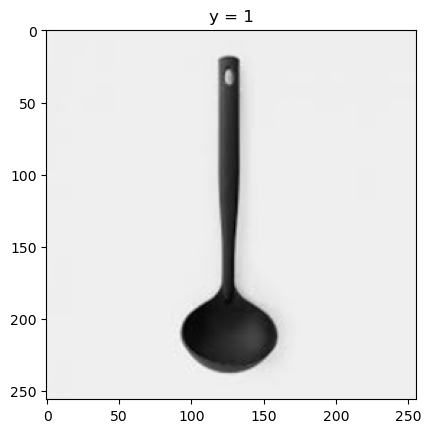

In [10]:
show_data(X_train[100],y_train[100])

### Create Pytorch Dataset Class object for training and validation dataset

In [35]:
class image_dataset(Dataset):
    def __init__(self,X,y, transform=None):
        self.x = X
        self.y = torch.tensor(y)

        self.len = len(X)
        self.transform = transform

    def __getitem__(self, index):
        sample = self.x[index],self.y[index]
        if self.transform:
            image = self.transform()
            sample = image,self.y[index]
        return sample

    def __len__(self):
        return self.len


In [36]:
train_dataset = image_dataset(X_train,y_train)
validation_dataset = image_dataset(X_val,y_val)

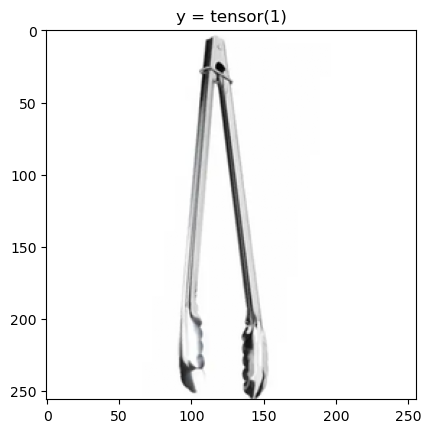

In [37]:
# Show the second image
show_data(train_dataset[0][0],train_dataset[0][1])

In [38]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataset_sizes = {'train':len(X_train),'val':len(X_val)}
dataset_sizes

{'train': 828, 'val': 409}

In [42]:
# Create a Data Loader for the training data 
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=50)
# Create a Data Loader for the validation data 
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=20)

### Create CNN model 

In [43]:
class CNN(nn.Module):

    # Contructor
    def __init__(self, out_1=256, out_2=128, num_classes=2):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=out_1, kernel_size=5, padding=2)
        self.maxpool1=nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        # Channel Width after this layer is 4
        self.maxpool2=nn.MaxPool2d(kernel_size=2)

        self.fc1 = nn.Linear(out_2 * 64 * 64, 56)
        self.fc2 = nn.Linear(56, num_classes)

    # Prediction
    def forward(self, x):
        # Puts the X value through each cnn, relu, and pooling layer and it is flattened for input into the fully connected layer
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

    # Outputs result of each stage of the CNN, relu, and pooling layers
    def activations(self, x):
        # Outputs activation this is not necessary
        z1 = self.cnn1(x)
        a1 = torch.relu(z1)
        out1 = self.maxpool1(a1)

        z2 = self.cnn2(out1)
        a2 = torch.relu(z2)
        out2 = self.maxpool2(a2)
        
        
        return z1, a1, z2, a2, out1, out2, 

# Create the model object using CNN class

model = CNN(num_classes=len(labels))

In [44]:
# check if dimensions of models's layer are correct
for x,y in train_loader:
    print(x.size())
    z = model(x)
    prob, yhat = torch.max(z.data, 1)
    print("z:",z)
    print("prob:",prob)
    print(yhat,y)
    break

torch.Size([50, 3, 256, 256])
z: tensor([[ 0.0853,  0.0582],
        [ 0.0884,  0.0519],
        [ 0.1068,  0.0035],
        [ 0.1070, -0.0643],
        [ 0.1165,  0.0323],
        [ 0.0952,  0.0442],
        [ 0.0919, -0.0268],
        [ 0.1226, -0.0036],
        [ 0.1489, -0.0557],
        [ 0.1225, -0.0523],
        [ 0.0821,  0.0414],
        [ 0.0857, -0.0296],
        [ 0.1082,  0.0022],
        [ 0.0822,  0.0596],
        [ 0.1104,  0.0366],
        [ 0.1135,  0.0421],
        [ 0.0940, -0.0242],
        [ 0.1317, -0.0204],
        [ 0.0961, -0.0108],
        [ 0.1071,  0.0084],
        [ 0.0943,  0.0356],
        [ 0.1026, -0.0235],
        [ 0.0856,  0.0511],
        [ 0.1005,  0.0447],
        [ 0.1016, -0.0015],
        [ 0.0746, -0.0177],
        [ 0.0904,  0.0296],
        [ 0.0894, -0.0323],
        [ 0.1207, -0.0212],
        [ 0.0831,  0.0113],
        [ 0.0955,  0.0646],
        [ 0.0862,  0.0454],
        [ 0.1059, -0.0594],
        [ 0.1057,  0.0151],
        [ 0.111

In [45]:
# We create a criterion which will measure loss
criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
# Create an optimizer that updates model parameters using the learning rate and gradient
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

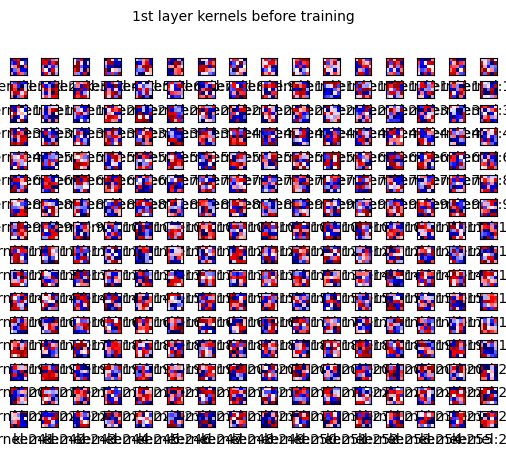

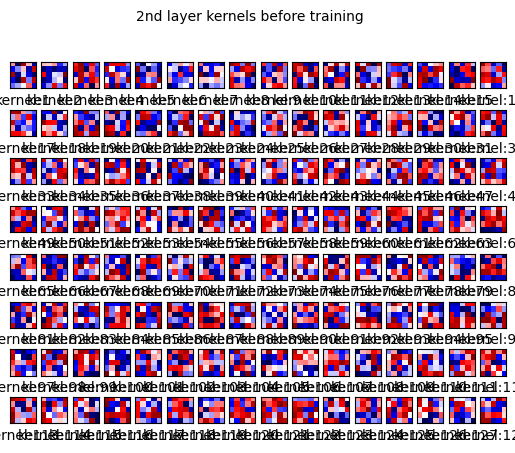

In [53]:
# Plot the parameters
plot_parameters(model.state_dict()['cnn1.weight'], number_rows=16, name="1st layer kernels before training ")
plot_parameters(model.state_dict()['cnn2.weight'], number_rows=8, name='2nd layer kernels before training' )

### Train model

In [47]:
# Number of times we want to train on the taining dataset
n_epochs=5
# List to keep track of cost and accuracy
cost_list=[]
accuracy_list=[]
# Size of the validation dataset
N_val=len(validation_dataset)

# Model Training Function
def train_model(n_epochs):
    since = time.time()
    # Loops for each epoch
    for epoch in range(n_epochs):
        print(f'Epoch {epoch}/{n_epochs - 1}')
        print('-' * 10)
        # Keeps track of cost for each epoch
        COST=0
        # For each batch in train loader
        for x, y in train_loader:
            # Resets the calculated gradient value, this must be done each time as it accumulates if we do not reset
            optimizer.zero_grad()
            # Makes a prediction based on X value
            z = model(x)
            # Measures the loss between prediction and acutal Y value
            loss = criterion(z, y)
            # Calculates the gradient value with respect to each weight and bias
            loss.backward()
            # Updates the weight and bias according to calculated gradient value
            optimizer.step()
            # Cumulates loss
            COST+=loss.data

        # Saves cost of training data of epoch
        cost_list.append(COST)
        # Keeps track of correct predictions
        correct=0
        # Perform a prediction on the validation  data
        for x_test, y_test in validation_loader:
            # Makes a prediction
            z = model(x_test)
            # The class with the max value is the one we are predicting
            _, yhat = torch.max(z.data, 1)
            # Checks if the prediction matches the actual value
            correct += (yhat == y_test).sum().item()

        # Calcualtes accuracy and saves it
        accuracy = correct / N_val
        accuracy_list.append(accuracy)
        print(f'Loss: {COST:.4f} Acc: {accuracy:.4f}')
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

train_model(n_epochs)

Epoch 0/4
----------
Loss: 16.2203 Acc: 0.3985
Epoch 1/4
----------
Loss: 11.9363 Acc: 0.5257
Epoch 2/4
----------
Loss: 11.6850 Acc: 0.5917
Epoch 3/4
----------
Loss: 11.6497 Acc: 0.5281
Epoch 4/4
----------
Loss: 11.6259 Acc: 0.6039
Training complete in 156m 13s


In [48]:
print(accuracy_list)

[0.39853300733496333, 0.5256723716381418, 0.5916870415647921, 0.5281173594132029, 0.6039119804400978]


In [49]:
torch.save(model, PATH)

NameError: name 'PATH' is not defined

In [50]:
torch.save(model,'/Users/anushree/Desktop/Dishwasher-safe Or Not/model_cnn.pkl')

### Plot the Loss and Accuracy vs Epoch graph

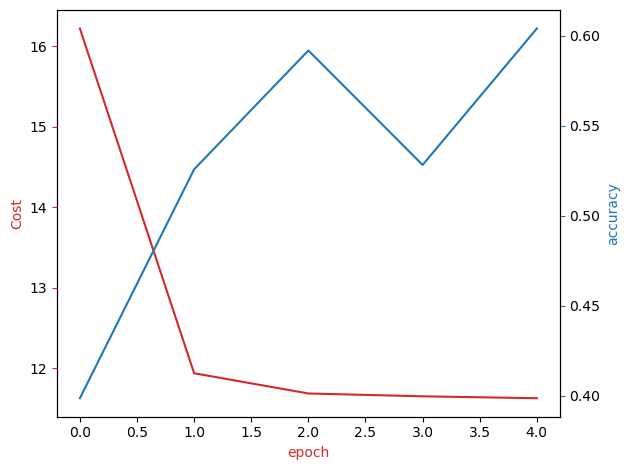

In [51]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(cost_list, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color) 
ax2.set_xlabel('epoch', color=color)
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

In [52]:
# Use the CNN activations class to see the steps
out = model.activations(train_dataset[1][0])
out

(tensor([[[ 0.0386,  0.0567, -0.0166,  ..., -0.0166,  0.0725,  0.1315],
          [-0.0516, -0.1524, -0.2851,  ..., -0.2851, -0.1000,  0.1002],
          [-0.2336, -0.2039, -0.4524,  ..., -0.4524, -0.1567,  0.0588],
          ...,
          [-0.2336, -0.2039, -0.4524,  ..., -0.4524, -0.1567,  0.0588],
          [-0.2415, -0.2242, -0.5118,  ..., -0.5118, -0.2859,  0.1114],
          [-0.2071, -0.1959, -0.2901,  ..., -0.2901, -0.1675,  0.1544]],
 
         [[ 0.0290,  0.2084,  0.0196,  ...,  0.0196, -0.0565,  0.0537],
          [ 0.0663,  0.1612,  0.0508,  ...,  0.0508, -0.0497,  0.1922],
          [ 0.4271,  0.6535,  0.7384,  ...,  0.7384,  0.5091,  0.7897],
          ...,
          [ 0.4271,  0.6535,  0.7384,  ...,  0.7384,  0.5091,  0.7897],
          [ 0.2754,  0.2865,  0.4929,  ...,  0.4929,  0.3067,  0.7192],
          [ 0.3231,  0.3177,  0.4839,  ...,  0.4839,  0.3806,  0.6373]],
 
         [[-0.6433, -0.2928, -0.1020,  ..., -0.1020,  0.1114,  0.3095],
          [-0.6531, -0.2679,